<a href="https://colab.research.google.com/github/mittalsaurab/FakeCurrencyRecognition/blob/master/500NoteDatasetTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd drive/My\ Drive/Colab\ Notebooks/FakeCurrencyIdentification

/content/drive/My Drive/Colab Notebooks/FakeCurrencyIdentification


In [3]:
import numpy as np

In [4]:
images = []
labels  = []

In [5]:
import os
import numpy as np
import cv2

# this will be the function used to resize and grayscale the the raw input image
def resize(img):
    img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)
    return img

def perCentreMean(img):
    # img = np.swapaxes(np.swapaxes(img, 1, 2), 0, 1)
    # img = img - IMAGE_MEAN
    return img

# for efficient memory storage :
# since the numbers are between 0 and 255, numpy's int16 datatype can be used
# secondly, we need to flatten the image array to store it efficiently ad row-major
# so for that, we will numpy's use numpy's ravel function with 'copy' flag = False
def generateDataForImages():
    
    noOfRows = 224
    noOfCols = 224
    
    # first all real currency notes' images and then all the fake ones'
    # i am skeptical of the consequences :-/
    label = 1
    inputArray = False
    
    for directory in ['500 Testing/New Real 4/', '500 Testing/New Fake 4/']:
        for filename in os.listdir(directory):
            img = cv2.imread(directory + filename)
            img = resize(img)
            
            # TRANSLATIONS
            # will produce (6 + 6 + 1) x (6 + 6 + 1) = 169 images
            # stride of 5 pixels along both axis along all 4 directions
            for x in range(30, -35, -5):
                for y in range(30, -35, -5):
                    translationMatrix = np.float32([ [1,0,x], [0,1,y] ])
                    imgTrns = cv2.warpAffine(img, translationMatrix, (noOfCols, noOfRows))
                    imgTrns = perCentreMean(imgTrns)
                    images.append(imgTrns)
                    labels.append(np.int32([label]))

            # ROTATIONS
            # we produce 41 different angles in the range of -10 to 10
            # with the step being equal to 0.5
            for angle in range(20, -21, -1):
                rotationMatrix = cv2.getRotationMatrix2D((noOfCols/2, noOfRows/2), float(angle)/2, 1)
                imgRotated = cv2.warpAffine(img, rotationMatrix, (noOfCols, noOfRows))
                imgRotated = perCentreMean(imgRotated)
                images.append(imgRotated)
                labels.append(np.int32([label]))

            # PROJECTIVE TRANSFORMATIONS for ZOOMING IN AND ZOOMING OUT
            # will produce (30 + 30) images for the dataset
            # 1ST ZOOMING IN ...
            for step in np.arange(0.001, 0.031, 0.001):
                srcPoints = np.float32([[int(step*(noOfCols-1)),int(step*(noOfRows-1))], [int((1-step)*(noOfCols-1)),int(step*(noOfRows-1))], [int(step*(noOfCols-1)),int((1-step)*(noOfRows-1))], [int((1-step)*(noOfCols-1)), int((1-step)*(noOfRows-1))]])
                dstPoints = np.float32([[0,0], [noOfCols-1,0], [0,noOfRows-1], [noOfCols-1,noOfRows-1]]) 
                projective_matrix = cv2.getPerspectiveTransform(srcPoints, dstPoints)
                imgZoomed = cv2.warpPerspective(img, projective_matrix, (noOfCols,noOfRows))
                imgZoomed = perCentreMean(imgZoomed)
                images.append(imgZoomed)
                labels.append(np.int32([label]))
            # 2ND ZOOMING OUT ...
            for step in np.arange(0.001, 0.031, 0.001):
                srcPoints = np.float32(np.float32([[0,0], [noOfCols-1,0], [0,noOfRows-1], [noOfCols-1,noOfRows-1]]))
                dstPoints = np.float32([[int(step*(noOfCols-1)),int(step*(noOfRows-1))], [int((1-step)*(noOfCols-1)),int(step*(noOfRows-1))], [int(step*(noOfCols-1)),int((1-step)*(noOfRows-1))], [int((1-step)*(noOfCols-1)), int((1-step)*(noOfRows-1))]]) 
                projective_matrix = cv2.getPerspectiveTransform(srcPoints, dstPoints)
                imgZoomed = cv2.warpPerspective(img, projective_matrix, (noOfCols,noOfRows))
                imgZoomed = perCentreMean(imgZoomed)
                images.append(imgZoomed)
                labels.append(np.int32([label]))

        # set label for fake images to come
        label = 0

In [6]:
generateDataForImages()

In [7]:
# file.close()
print(len(images))
print(len(labels))

7020
7020


In [8]:
import random
temp = list(zip(images, labels)) 
random.shuffle(temp) 
Xdata, ydata = zip(*temp) 

In [9]:
Xdata = np.array(Xdata)
ydata = np.array(ydata)

In [11]:
n = len(Xdata)
Xtrain = Xdata[:int(0.9*n)]
# Xval = Xdata[int(0.7*n):int(0.9*n)]
Xtest = Xdata[int(0.9*n):]

ytrain = ydata[:int(0.9*n)]
# yval = ydata[int(0.7*n):int(0.9*n)]
ytest = ydata[int(0.9*n):]

from keras.utils import to_categorical

ytrain = to_categorical(ytrain)
# yval = to_categorical(yval)
ytest = to_categorical(ytest)

In [12]:
Xtrain.shape

(6318, 224, 224, 3)

In [13]:
from keras.applications import vgg16
from keras.models import Sequential,Model
from keras.layers import Dense, Flatten,Input,GlobalAveragePooling2D,Dropout
from keras.optimizers import Adam

In [14]:
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224,3))
len(vgg_conv.layers)

58892288/58889256 [==============================] - 1s 0us/step


19

In [15]:
for layer in vgg_conv.layers[:]:
    layer.trainable = False


In [16]:
l2 = GlobalAveragePooling2D()(vgg_conv.output)
l3 = Dense(256,activation='relu')(l2)
l4 = Dropout(0.5)(l3)
l5 = Dense(2,activation='softmax')(l4)

final_model = Model(vgg_conv.input,l5)

In [17]:
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
rr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=1,min_lr = 0.00000001)
# er = EarlyStopping(monitor='val_loss',patience = 2,verbose=1)
mc = ModelCheckpoint("model_weights.hdf5",monitor='val_loss',save_best_only=True,period=1)

In [18]:
adam = Adam(lr=0.0003)
final_model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

In [20]:
hist = final_model.fit(Xtrain,ytrain,epochs = 10, batch_size = 16,callbacks=[rr,mc])


Epoch 1/10
395/395 [==============================] - 50s 127ms/step - loss: 0.9031 - accuracy: 0.6792
Epoch 2/10
395/395 [==============================] - 49s 123ms/step - loss: 0.3753 - accuracy: 0.8253
Epoch 3/10
395/395 [==============================] - 49s 123ms/step - loss: 0.2868 - accuracy: 0.8686
Epoch 4/10
395/395 [==============================] - 49s 124ms/step - loss: 0.2234 - accuracy: 0.9031
Epoch 5/10
395/395 [==============================] - 49s 124ms/step - loss: 0.1868 - accuracy: 0.9194
Epoch 6/10
395/395 [==============================] - 49s 124ms/step - loss: 0.1566 - accuracy: 0.9330
Epoch 7/10
395/395 [==============================] - 49s 124ms/step - loss: 0.1434 - accuracy: 0.9403
Epoch 8/10
395/395 [==============================] - 49s 124ms/step - loss: 0.1370 - accuracy: 0.9380
Epoch 9/10
395/395 [==============================] - 49s 125ms/step - loss: 0.1201 - accuracy: 0.9457
Epoch 10/10
395/395 [==============================] - 49s 124ms/step - l

In [30]:
(l,acc) = final_model.evaluate(Xtest,ytest)
print("Accuracy on validation dataset for 500 is : "+str(acc))

22/22 [==============================] - 5s 215ms/step - loss: 0.0847 - accuracy: 0.9658
Accuracy on validation dataset for 500 is : 0.9658119678497314


In [22]:
final_model.save_weights("500_model.hdf5")
# final_model.load_weights("500_model.hdf5");

In [23]:
(l,acc) = final_model.evaluate(Xtest,ytest)

22/22 [==============================] - 7s 336ms/step - loss: 0.0847 - accuracy: 0.9658


In [24]:
acc

0.9658119678497314

In [25]:
import matplotlib.pyplot as plt


Actual :Fake
Predicted :Fake


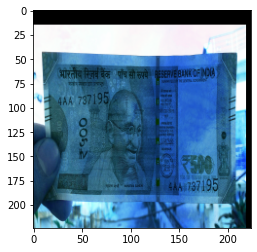

In [26]:
def decide(x):
  if x:
    return "Real"
  else:
    return "Fake"

r = np.random.randint(4000)
plt.imshow(Xtrain[r])
print("Actual :" + str(decide(np.argmax(ytrain[r]))))
print("Predicted :" + str(decide(np.argmax(final_model.predict(Xtrain[r:r+1])[0]))))

In [27]:
import sklearn.metrics as metrics
confusion_matrix = metrics.confusion_matrix(ytrain.argmax(axis=1), final_model.predict(Xtrain).argmax(axis=1))

In [28]:
print("Confusion matrix for 500 notes : ")
print(confusion_matrix)

Confusion matrix for 500 notes : 
[[3142    6]
 [ 153 3017]]
